## PSF
Choose image and then...
1) Apply psf
2) Add noise
3) Deconvolve

In [12]:
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

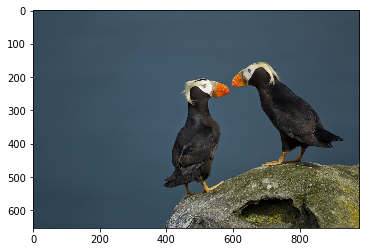

In [13]:
# First import and show image
image = imread("bird.png")
image = image[:,:,:3]/255 
# ^ Discard alpha channel, convert 255-int to 1.0-float
plt.imshow(image)

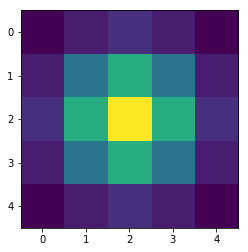

In [14]:
psf = np.load("example_psf.npy")
plt.imshow(psf)

kernel = psf.copy()[:,:,np.newaxis]
nx,ny,nc = kernel.shape
#kernel

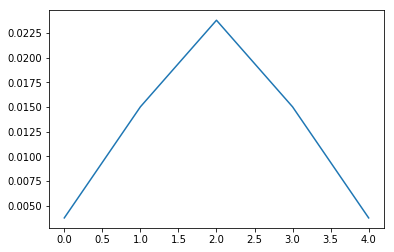

In [15]:
plt.plot(range(ny),kernel[-1,:,0])

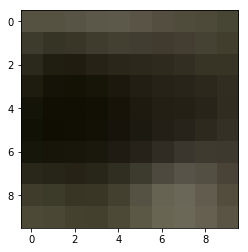

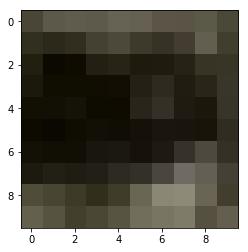

In [16]:
# Now we convolve the two
mag = np.sum(kernel)
blurred_image_slice = ndimage.convolve(image, kernel/mag)

a, b = 600, 610
plt.imshow(blurred_image_slice[a:b,a:b])
plt.show()
plt.imshow(image[a:b,a:b])
plt.show()

We see the effect of the convolution of the image with the psf.  Now let's see the effect of noise.

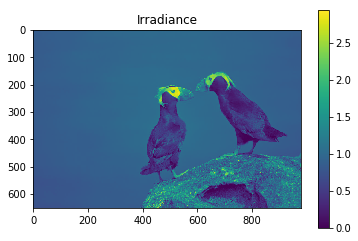

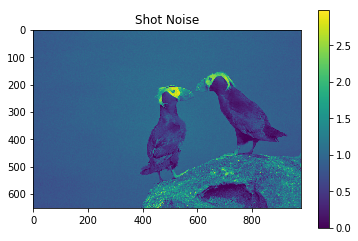

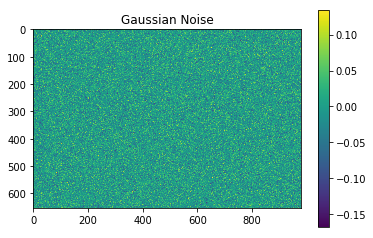

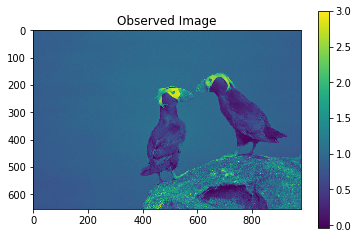

In [17]:
image_irr = np.sum(image, axis=-1) # Approximate irradiance as R+G+B
plt.imshow(image_irr)
plt.title("Irradiance")
plt.colorbar()
plt.show()

# Shot (photon) noise is poisson-distributed with \lambda = # of photons
alpha = 1e3 # Scaling factor, photons per unit irradiance
shot_noise = np.random.poisson(lam=image_irr*alpha)/alpha
plt.title("Shot Noise")
plt.imshow(shot_noise)
plt.colorbar()
plt.show()

# Gaussian noise is just electrical noise with mean zero and constant std.
gauss_scaling = 1e-1
gauss_noise = np.random.normal(loc=0, scale=0.3, size=image_irr.shape)*gauss_scaling
plt.title("Gaussian Noise")
plt.imshow(gauss_noise)
plt.colorbar()
plt.show()

image_obs = image_irr + shot_noise + gauss_noise
image_obs = image_obs * 3/np.max(image_obs) #rescale
plt.title("Observed Image")
plt.imshow(image_obs)
plt.colorbar()
plt.show()

We will convolve the image with our psf, add in the noise, and then implement a couple deconvolution methods and compare.

(653, 980, 3) (5, 5, 1)
(653, 980) (5, 5)


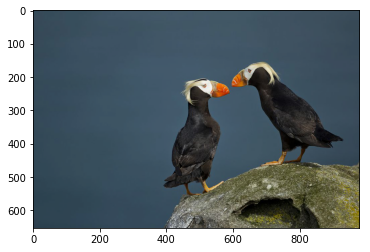

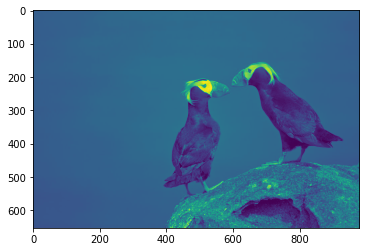

In [18]:
# Convert from 3 color channel to irradiance
#plt.imshow(ndimage.convolve(image_obs,kernel[:,:,0]))

sx, sy = 100,100 # image_r.shape
n = 8
image_r = image_irr

psf = kernel[:,:,0]
ref = image_r.copy()

print(image.shape, kernel.shape)
print(ref.shape, psf.shape)


plt.imshow(ndimage.convolve(image,kernel/mag))
plt.show()
plt.imshow(ndimage.convolve(ref,psf))
plt.show()

In [19]:
psf_test = np.zeros_like(ref)
psf_test[int(np.floor(ref.shape[0]/2)-np.floor(psf.shape[0]/2)):int(np.floor(ref.shape[0]/2)+np.ceil(psf.shape[0]/2)),
         int(np.floor(ref.shape[1]/2)-np.floor(psf.shape[1]/2)):int(np.floor(ref.shape[1]/2)+np.ceil(psf.shape[1]/2))] = psf
psf = np.copy(psf_test)

Mean difference between original and convolved with noise:  -0.02427649240704897
Mean Error Wiener:  -0.008468955005002235
Mean Error RL:  0.19594221685319574


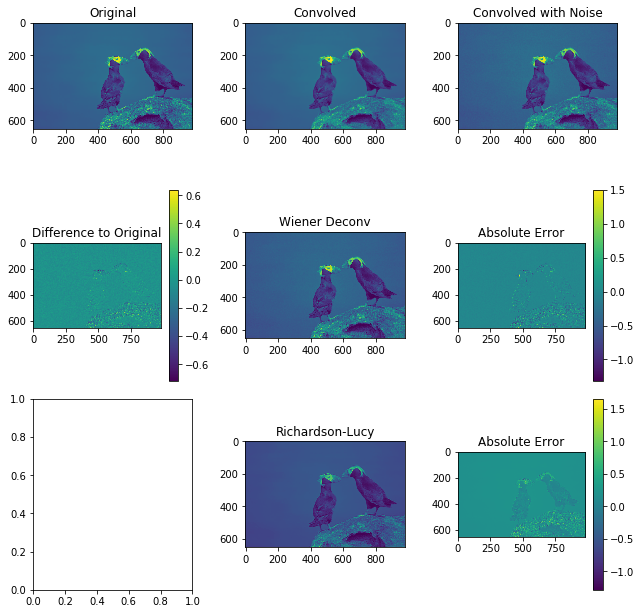

In [20]:
from scipy import stats
from scipy.fftpack import fftn, ifftn, fftshift, ifftshift

from skimage import color, data, restoration

def F(f):
    return fftshift(fftn(f))

def convolve(f, g):
    return fftshift(ifftn(ifftshift(F(f) * F(g))))

def deconvolve(f,g):
    return fftshift(ifftn(ifftshift(F(f) / F(g))))

def de_unsup_wiener(f, g):
    params = {'min_iter':200}
    return restoration.unsupervised_wiener(f, g, user_params=params)
  
def de_wiener(f, g, SNR=10):
    #https://en.wikipedia.org/wiki/Wiener_deconvolution
    Fg2 = np.absolute(F(g))**2
    return fftshift(fftn(F(f)/F(g) * Fg2/(Fg2 + 1/SNR)))

def de_rich_lucy(f, g, iters=10):
    u = f.copy() #initial guess
    for ix in range(iters):
        u = u * convolve(f/convolve(u,g),np.flip(g, axis=-1))
    return np.absolute(u)

  
from scipy import signal



ref_conv = convolve(ref, psf)
ref_conv_noise = ref_conv + shot_noise + gauss_noise
ref_conv_noise = ref_conv_noise * 3/np.max(ref_conv_noise) #rescale

ref_deconv    = deconvolve(ref_conv_noise, psf)
#ref_de_unsup_wiener, _= de_unsup_wiener(ref_conv, psf)
ref_de_wiener = de_wiener(ref_conv_noise, psf,SNR=1e1) 
# ^ In reality, SNR should be calculated, but for the sake of demonstration, we give it as a constant.
ref_de_wiener = ref_de_wiener[::-1,::-1]*(3/np.max(ref_de_wiener))
ref_de_rich_lucy = de_rich_lucy(ref_conv, psf, iters=2)
ref_de_rich_lucy = ref_de_rich_lucy*(3/np.max(ref_de_rich_lucy))




f, axes = plt.subplots(3,3,figsize=(9,9))

ax_orig = axes[0,0]
ax_orig.imshow(ref)
ax_orig.set_title("Original")

#ax_psf = axes[0,1] 
#ax_psf.imshow(psf[320:340, 480:500])
#ax_psf.set_title("PSF Kernel")

ax_conv = axes[0,1]
ax_conv.imshow(np.absolute(ref_conv))
ax_conv.set_title("Convolved")
 
ax_deconv= axes[0,2]
ax_deconv.imshow(np.absolute(ref_conv_noise))
ax_deconv.set_title("Convolved with Noise")   

ax_diff = axes[1,0]
cbar_d = ax_diff.imshow(np.absolute(image_irr)-np.absolute(ref_conv_noise))
ax_diff.set_title("Difference to Original")
f.colorbar(cbar_d, ax=ax_diff)
print("Mean difference between original and convolved with noise: ", 
      np.mean(np.absolute(image_irr)-np.absolute(ref_conv_noise)))
    
#ax_deconv= axes[1,1]
#ax_deconv.imshow(np.absolute(ref_de_wiener))
#ax_deconv.set_title("Unsupervised Wiener")

ax_wiener = axes[1,1]
ax_wiener.imshow(np.absolute(ref_de_wiener))
ax_wiener.set_title("Wiener Deconv")


ax_error_w = axes[1,2]
cbar_w = ax_error_w.imshow(np.absolute(image_irr)-np.absolute(ref_de_wiener))
ax_error_w.set_title("Absolute Error")
f.colorbar(cbar_w, ax=ax_error_w)
print("Mean Error Wiener: ", np.mean(np.absolute(image_irr)-np.absolute(ref_de_wiener)))

ax_rich_lucy= axes[2,1]
ax_rich_lucy.imshow(np.absolute(ref_de_rich_lucy))
ax_rich_lucy.set_title("Richardson-Lucy")

ax_error_rl = axes[2,2]
cbar_rl = ax_error_rl.imshow(np.absolute(image_irr)-np.absolute(ref_de_rich_lucy))
ax_error_rl.set_title("Absolute Error")
#cbar.set_clim(vmin=-1, vmax=1)
f.colorbar(cbar_rl, ax=ax_error_rl)
print("Mean Error RL: ", np.mean(np.absolute(image_irr)-np.absolute(ref_de_rich_lucy)))
                 
plt.tight_layout()
plt.show()


The Wiener Deconvolution deconvolves to reduce the error from ~3% to an error of ~1%.  Unsupervised Wiener, not shown, was similar.

The Richardson-Lucy Deconvolution achieves an error of around 19%.  Future work could play with number of iterations and initial guess of image.

Both of these perform worse with increasing noise.

Error is defined as the mean of the difference between the original and the deconvolved solution.

Future work could determine how error increases as noise increases.